# Some adhoc test/checks for functions within `ar_model`

In [4]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [5]:
import xarray as xr

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import pandas as pd

from src import utils

import matplotlib.pyplot as plt

from src import ar_model

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [6]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 12

In [7]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [8]:
DATA_DIR = "../../data/processed"

# Let's just fit to observations for now, though a fit to historical model runs may be more appropriate

In [9]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = (
    utils.calculate_period_AMV_index(
        HadISST["sst"],
        [12, 1, 2, 3],
    )
    .rename("AMV")
    .compute()
)
AMV = utils.round_to_start_of_month(AMV, dim="time")

HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = (
    utils.calculate_period_NAO_index(
        HadSLP["slp"],
        [12, 1, 2, 3],
    )
    .rename("NAO")
    .compute()
)

AMV, NAO = xr.align(AMV, NAO)

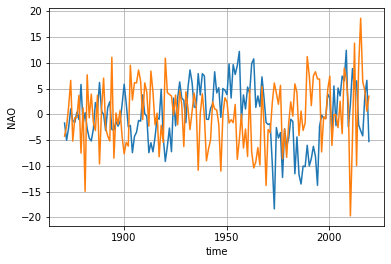

In [10]:
(40 * AMV).plot(label="AMV")
NAO.plot(label="NAO")
plt.grid()

# Fit a VAR model

In [14]:
input_data = pd.concat(
    (AMV.to_dataframe(), NAO.to_dataframe()),
    axis=1,
)

## Check that input series are stationary

In [15]:
signif = 0.05

for var in input_data.columns:
    res = adfuller(input_data[var])
    if res[1] < signif:
        print(f"{var} is stationary")
    else:
        print(f"{var} is non-stationary")

AMV is stationary
NAO is stationary


## As a check, do a VAR fit myself and compare to `statsmodels`

In [16]:
order = 2

In [17]:
def my_OLS_fit(predictor, response):
    XtX = np.matmul(predictor.T, predictor)
    XtY = np.matmul(predictor.T, response)
    XtX_Inv = np.linalg.inv(XtX)

    b = np.matmul(XtX_Inv, XtY)

    return b

In [18]:
# Lag order with this approach is [y1_lag2, y1_lag1, y2_lag2, y2_lag1]
predictor = sliding_window_view(input_data.to_numpy(), window_shape=order, axis=0)
predictor = predictor.reshape((predictor.shape[0], -1))[:-1, :]

response = input_data.to_numpy()[order:]

my_params = pd.DataFrame(
    my_OLS_fit(predictor, response),
    index=["L2.AMV", "L1.AMV", "L2.NAO", "L1.NAO"],
    columns=["AMV", "NAO"],
)
my_params

,AMV,NAO
L2.AMV,0.258294,-9.742450
L1.AMV,0.435933,-1.676509
L2.NAO,0.000539,-0.012159
L1.NAO,-0.000936,0.062240


In [15]:
their_params = VAR(input_data).fit(order, trend="n").params
their_params

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


## Check that `res.sigma2` returned by `statsmodels` is just the variance of the residuals

In [16]:
from statsmodels.tsa.ar_model import AutoReg

res = AutoReg(input_data.to_numpy()[:, 0], lags=2, trend="n").fit()

print(f"Square root of res.sigma2: {np.sqrt(res.sigma2)}")
print(f"Standard deviation of residuals: {np.std(res.resid)}")

Square root of res.sigma2: 0.10972550897069776
Standard deviation of residuals: 0.10972513235786074


## Check that `generate_samples` matches `statsmodels.tsa.vector_ar.var_model.VARProcess`

In [17]:
AMV_input = AMV.to_dataset()
NAO_input = NAO.to_dataset()

VAR_input = xr.merge((AMV_input, NAO_input))

In [18]:
order = 2
n_times = 50

res = VAR(VAR_input.to_dataframe()).fit(order, trend="n")

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


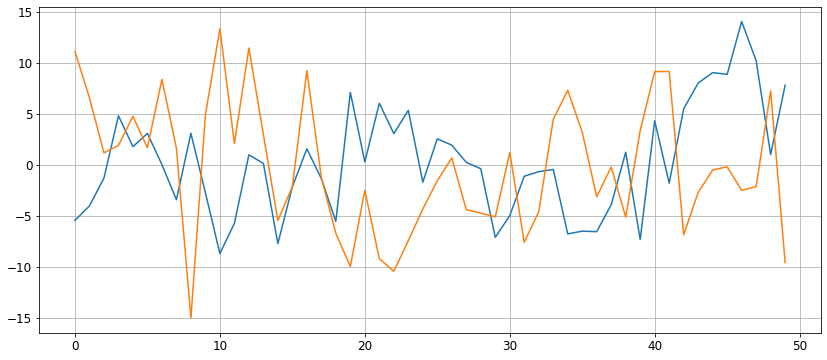

In [19]:
a = res.simulate_var(n_times + order, seed=0)[order:]

plt.plot(40 * a[:, 0])
plt.plot(a[:, 1])
plt.grid()

In [20]:
VAR_params = ar_model.fit(VAR_input, n_lags=order)

b = ar_model.generate_samples(VAR_params, n_times=n_times, n_samples=1, seed=0)

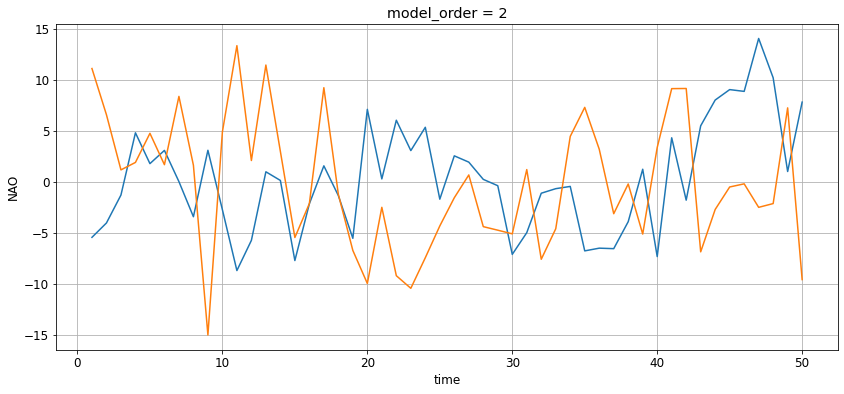

In [21]:
(40 * b["AMV"]).plot()
b["NAO"].plot()
plt.grid()

## Check that predictions match `statsmodels` method

#### VAR model

In [40]:
order = 4
n_steps = 10
n_members = 10

In [41]:
VAR_params = ar_model.fit(VAR_input, n_lags=order)

inits = ar_model.generate_samples(VAR_params, n_times=100, n_samples=1)

# Supress the noise terms
VAR_params = xr.concat(
    (
        VAR_params.isel(params=slice(-2)),
        1e-8 * VAR_params.isel(params=slice(-2, None)),
    ),
    dim="params",
)

In [42]:
my_forecasts = ar_model.predict(
    VAR_params, inits, n_steps=n_steps, n_members=n_members
).squeeze()

res = VAR(VAR_input.to_stacked_array(new_dim="var", sample_dims=["time"]).values).fit(
    order, trend="n"
)

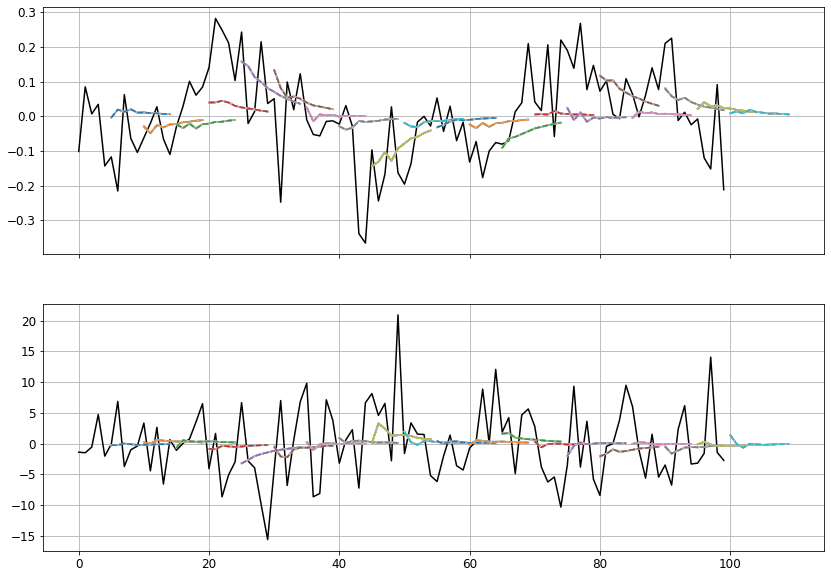

In [43]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

axs[0].plot(inits["AMV"], color="k")
axs[1].plot(inits["NAO"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    for m in my_forecast.member:
        axs[0].plot(lead, my_forecast["AMV"].sel(member=m), color=[0.7, 0.7, 0.7])
        axs[1].plot(lead, my_forecast["NAO"].sel(member=m), color=[0.7, 0.7, 0.7])

    their_forecast = res.forecast(
        inits.to_stacked_array(new_dim="var", sample_dims=["time"]).values[:init],
        n_steps,
    )
    axs[0].plot(lead, their_forecast[:, 0], linestyle="--")
    axs[1].plot(lead, their_forecast[:, 1], linestyle="--")

axs[0].grid()
axs[1].grid()

#### AR model

In [44]:
order = 2
n_steps = 10
n_members = 10

In [61]:
AR_params = ar_model.fit(AMV_input, n_lags=order)

inits = ar_model.generate_samples(AR_params, n_times=100, n_samples=1)

# Refit to inits so that can use AutoReg predict function
AR_params = ar_model.fit(inits, n_lags=order)

# Supress the noise terms
AR_params = xr.concat(
    (
        AR_params.isel(params=slice(-1)),
        1e-8 * AR_params.isel(params=slice(-1, None)),
    ),
    dim="params",
)

In [62]:
my_forecasts = ar_model.predict(
    AR_params, inits, n_steps=n_steps, n_members=n_members
).squeeze()

res = AutoReg(inits["AMV"].values, lags=order, trend="n").fit()

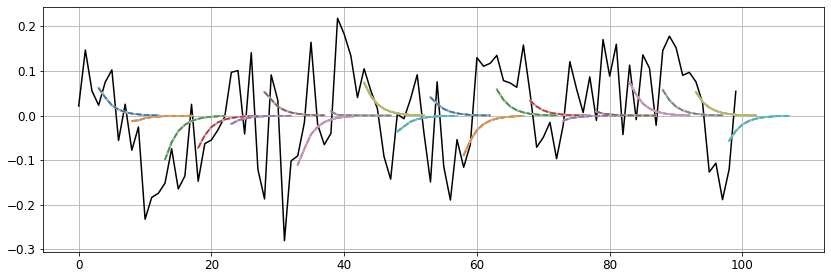

In [63]:
fig = plt.figure(figsize=(14, 4.5))
ax = fig.subplots(1, 1)

ax.plot(inits["AMV"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    for m in my_forecast.member:
        ax.plot(lead, my_forecast["AMV"].sel(member=m), color=[0.7, 0.7, 0.7])

    their_forecast = res.predict(init, init + n_steps - 1, dynamic=True)
    ax.plot(lead, their_forecast, linestyle="--")

ax.grid()

## Test functions when there are multiple params

#### Fit AMV and NAO AR params at the same time and compare to statsmodels

In [64]:
input_data = (
    xr.concat((AMV, NAO), dim="variable")
    .assign_coords({"variable": ["AMV", "NAO"]})
    .to_dataset(name="dummy")
)

AR_params = ar_model.fit(input_data, n_lags="select_order", kwargs={"maxlag": 10})

[1 2]


In [65]:
print(f"My AMV coefs: {AR_params['dummy'].sel(variable='AMV')[:-1].values}")
print(f"My AMV sigma2: {AR_params['dummy'].sel(variable='AMV')[-1:].values}")

ar_lags = ar_select_order(AMV.values, maxlag=10, trend="n").ar_lags
n_lags = len(ar_lags) if ar_lags is not None else 0
res = AutoReg(AMV.values, lags=n_lags, trend="n").fit()

print(f"sm AMV coefs: {res.params}")
print(f"sm AMV sigma2: {res.sigma2}")

My AMV coefs: [0.44292607 0.25604035]
My AMV sigma2: [0.01203969]
[1 2]
sm AMV coefs: [0.44292607 0.25604035]
sm AMV sigma2: 0.012039687318878676


In [66]:
print(f"My NAO coefs: {AR_params['dummy'].sel(variable='NAO')[:-1].values}")
print(f"My NAO sigma2: {AR_params['dummy'].sel(variable='NAO')[-1:].values}")

ar_lags = ar_select_order(NAO.values, maxlag=10, trend="n").ar_lags
n_lags = len(ar_lags) if ar_lags is not None else 0
res = AutoReg(NAO.values, lags=n_lags, trend="n").fit()

print(f"sm NAO coefs: {res.params}")
print(f"sm NAO sigma2: {res.sigma2}")

My NAO coefs: [nan nan]
My NAO sigma2: [36.64092375]
sm NAO coefs: []
sm NAO sigma2: 36.64092374981912


#### Fit a VAR model to the same data multiple times

In [67]:
input_data = xr.concat([VAR_input] * 3, dim="dim1")
input_data = xr.concat([input_data] * 5, dim="dim2")

In [68]:
VAR_params = ar_model.fit(input_data, n_lags=order)
my_VAR_params = VAR_params.isel(dim1=0, dim2=0)

In [69]:
res = VAR(VAR_input.to_stacked_array(new_dim="var", sample_dims=["time"]).values).fit(
    order, trend="n"
)

print(f"My AMV coefs: {my_VAR_params['AMV'][:-2].values}")
print(f"My AMV sigma2: {my_VAR_params['AMV'][-2:].values}")
print(f"sm AMV coefs: {res.params[:,0]}")
print(f"sm AMV sigma2: {res.sigma_u[:,0]}\n")

print(f"My NAO coefs: {my_VAR_params['NAO'][:-2].values}")
print(f"My NAO sigma2: {my_VAR_params['NAO'][-2:].values}")
print(f"sm NAO coefs: {res.params[:,1]}")
print(f"sm NAO sigma2: {res.sigma_u[:,1]}")

My AMV coefs: [ 0.43593261 -0.00093573  0.25829353  0.00053861]
My AMV sigma2: [ 0.01233732 -0.09165271]
sm AMV coefs: [ 0.43593261 -0.00093573  0.25829353  0.00053861]
sm AMV sigma2: [ 0.01233732 -0.09165271]

My NAO coefs: [-1.67650882  0.06223984 -9.74244953 -0.01215923]
My NAO sigma2: [-0.09165271 35.27252659]
sm NAO coefs: [-1.67650882  0.06223984 -9.74244953 -0.01215923]
sm NAO sigma2: [-0.09165271 35.27252659]


In [70]:
print(
    f"VAR params are the same across all dimensions: {(VAR_params - my_VAR_params == 0).all().to_array().values}"
)

VAR params are the same across all dimensions: [ True  True]


#### Test that `generate_samples` can handle multiple sets of params

#### AR process

In [114]:
my_samples = ar_model.generate_samples(AR_params, n_times=n_times, n_samples=2, seed=0)

Text(0, 0.5, 'AMV')

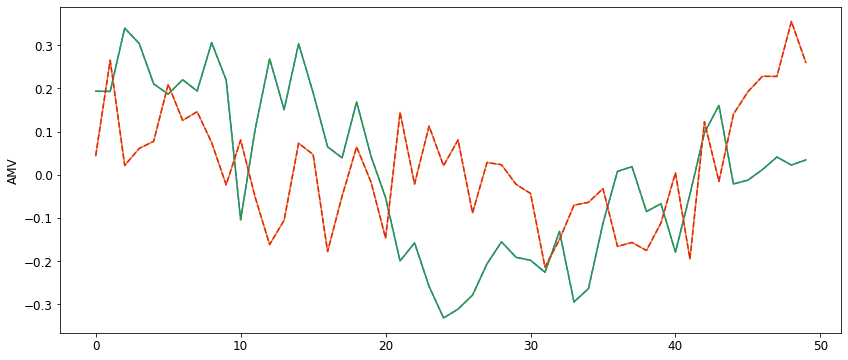

In [127]:
variable = "AMV"

coefs = np.concatenate(
    ([1], -AR_params["dummy"].sel(variable=variable)[:-1].dropna("params").values)
)
sigma2 = AR_params["dummy"].sel(variable=variable)[-1:].dropna("params").values

process = ArmaProcess(ar=coefs)

their_samples = process.generate_sample(
    nsample=(n_times, 2),
    scale=np.sqrt(sigma2),
    axis=0,
    distrvs=np.random.RandomState(seed=0).standard_normal,
).astype("float32")

plt.plot(samples["dummy"].sel(variable=variable))
plt.plot(their_samples, linestyle="--")
plt.ylabel(variable)

Text(0, 0.5, 'NAO')

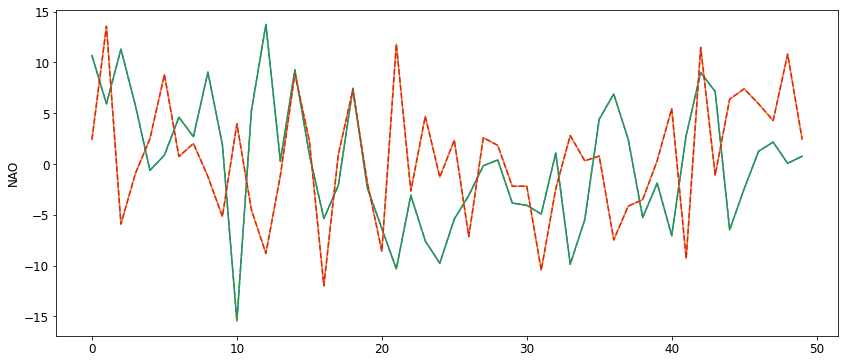

In [128]:
variable = "NAO"

coefs = np.concatenate(
    ([1], -AR_params["dummy"].sel(variable=variable)[:-1].dropna("params").values)
)
sigma2 = AR_params["dummy"].sel(variable=variable)[-1:].dropna("params").values

process = ArmaProcess(ar=coefs)

their_samples = process.generate_sample(
    nsample=(n_times, 2),
    scale=np.sqrt(sigma2),
    axis=0,
    distrvs=np.random.RandomState(seed=0).standard_normal,
).astype("float32")

plt.plot(samples["dummy"].sel(variable=variable))
plt.plot(their_samples, linestyle="--")
plt.ylabel(variable)

#### VAR process

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


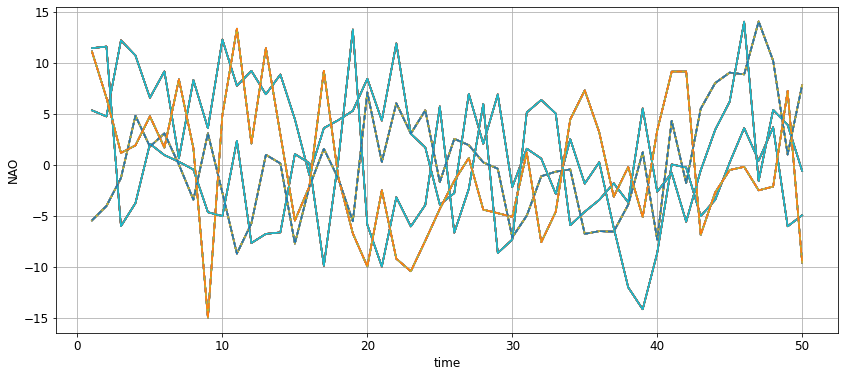

In [129]:
samples = ar_model.generate_samples(VAR_params, n_times=n_times, n_samples=2, seed=0)

_ = (
    (40 * samples["AMV"])
    .stack(dummy=["dim1", "dim2", "sample"])
    .plot.line(x="time", add_legend=False)
)
_ = (
    samples["NAO"]
    .stack(dummy=["dim1", "dim2", "sample"])
    .plot.line(x="time", add_legend=False)
)

res = VAR(VAR_input.to_dataframe()).fit(order, trend="n")
a = res.simulate_var(n_times + order, seed=0)[order:]

plt.plot(samples["AMV"].time, 40 * a[:, 0], linestyle="--")
plt.plot(samples["NAO"].time, a[:, 1], linestyle="--")
plt.grid()

#### Test that predictions match `statsmodels` when there are multiple params

#### VAR model

In [138]:
order = 4
n_steps = 10
n_members = 10

In [139]:
input_data = xr.concat([VAR_input] * 3, dim="dim1")
input_data = xr.concat([input_data] * 5, dim="dim2")

In [140]:
VAR_params = ar_model.fit(input_data, n_lags=order)

inits = ar_model.generate_samples(VAR_params, n_times=100, n_samples=1)

# Reduce the noise component
VAR_params = xr.concat(
    (
        VAR_params.isel(params=slice(-2)),
        1e-8 * VAR_params.isel(params=slice(-2, None)),
    ),
    dim="params",
)

In [141]:
my_forecasts = ar_model.predict(
    VAR_params, inits, n_steps=n_steps, n_members=10
).squeeze()

res = VAR(VAR_input.to_stacked_array(new_dim="var", sample_dims=["time"]).values).fit(
    order, trend="n"
)

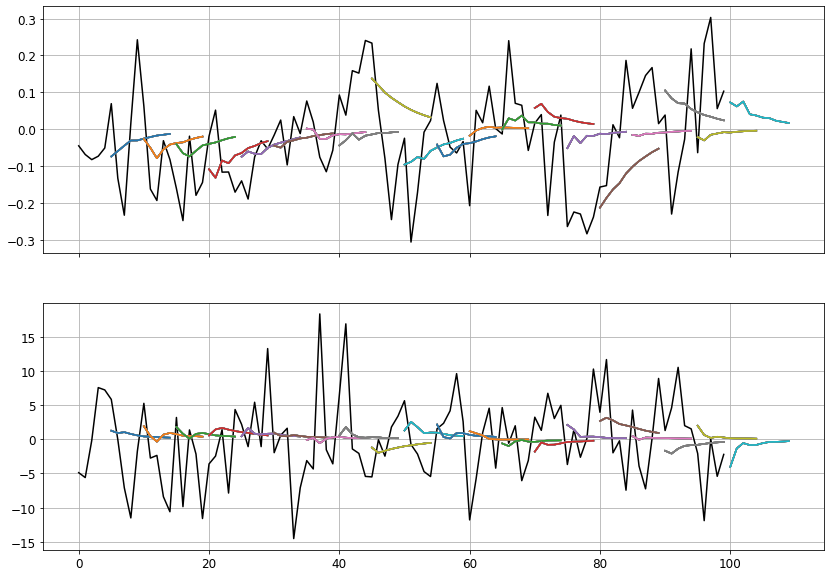

In [142]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

dim1 = 0
dim2 = 0

axs[0].plot(inits["AMV"].isel(dim1=dim1, dim2=dim2), color="k")
axs[1].plot(inits["NAO"].isel(dim1=dim1, dim2=dim2), color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.isel(dim1=dim1, dim2=dim2).sel(init=init)

    lead = my_forecast.lead + init
    for member in my_forecast.member:
        axs[0].plot(lead, my_forecast["AMV"].sel(member=member), color="grey")
        axs[1].plot(lead, my_forecast["NAO"].sel(member=member), color="grey")

    their_forecast = res.forecast(
        inits.isel(dim1=dim1, dim2=dim2)
        .to_stacked_array(new_dim="var", sample_dims=["time"])
        .values[:init],
        n_steps,
    )
    axs[0].plot(lead, their_forecast[:, 0])
    axs[1].plot(lead, their_forecast[:, 1])

axs[0].grid()
axs[1].grid()

#### AR model

In [143]:
order = "select_order"
n_steps = 10
n_members = 10

In [144]:
input_data = (
    xr.concat((AMV, NAO), dim="variable")
    .assign_coords({"variable": ["AMV", "NAO"]})
    .to_dataset(name="dummy")
)

AR_params = ar_model.fit(input_data, n_lags=order, kwargs={"maxlag": 10})

inits = ar_model.generate_samples(
    AR_params, n_times=input_data.sizes["time"], n_samples=1
)

AR_params = ar_model.fit(inits, n_lags=order, kwargs={"maxlag": 10})

# Reduce the noise component
# Supress the noise terms
AR_params = xr.concat(
    (
        AR_params.isel(params=slice(-1)),
        1e-8 * AR_params.isel(params=slice(-1, None)),
    ),
    dim="params",
)

[1 2]
[1 2]
[1]


In [146]:
my_forecasts = ar_model.predict(
    AR_params, inits, n_steps=n_steps, n_members=10
).squeeze()

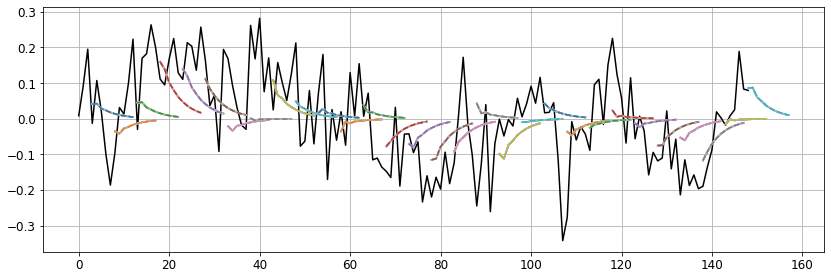

In [147]:
variable = "AMV"

inits_plot = inits["dummy"].sel(variable=variable)

my_forecasts_plot = my_forecasts["dummy"].sel(variable=variable)

res = AutoReg(
    inits_plot.values,
    lags=AR_params["model_order"].sel(variable=variable).item(),
    trend="n",
).fit()

fig = plt.figure(figsize=(14, 4.5))
ax = fig.subplots(1, 1)

ax.plot(inits_plot, color="k")

for init in my_forecasts_plot.init.values[::5]:
    my_forecast = my_forecasts_plot.sel(init=init)

    lead = my_forecast.lead + init
    for m in my_forecast.member:
        ax.plot(lead, my_forecast.sel(member=m), color=[0.7, 0.7, 0.7])

    their_forecast = res.predict(init, init + n_steps - 1, dynamic=True)
    ax.plot(lead, their_forecast, linestyle="--")

ax.grid()

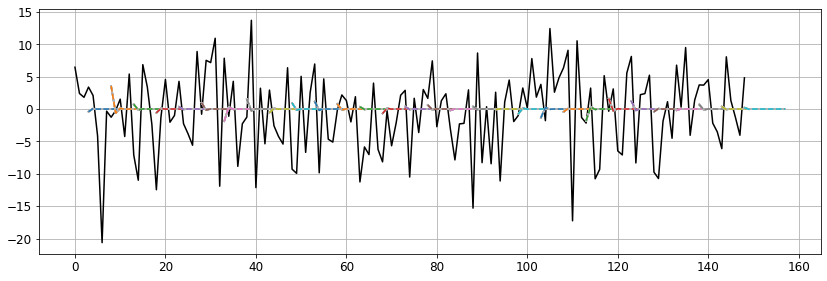

In [148]:
variable = "NAO"

inits_plot = inits["dummy"].sel(variable=variable)

my_forecasts_plot = my_forecasts["dummy"].sel(variable=variable)

res = AutoReg(
    inits_plot.values,
    lags=AR_params["model_order"].sel(variable=variable).item(),
    trend="n",
).fit()

fig = plt.figure(figsize=(14, 4.5))
ax = fig.subplots(1, 1)

ax.plot(inits_plot, color="k")

for init in my_forecasts_plot.init.values[::5]:
    my_forecast = my_forecasts_plot.sel(init=init)

    lead = my_forecast.lead + init
    for m in my_forecast.member:
        ax.plot(lead, my_forecast.sel(member=m), color=[0.7, 0.7, 0.7])

    their_forecast = res.predict(init, init + n_steps - 1, dynamic=True)
    ax.plot(lead, their_forecast, linestyle="--")

ax.grid()